In [1]:
import sys
root_dir = !cd .. &&pwd
root_dir = root_dir[0] + "/"
sys.path.insert(0, root_dir)

In [2]:
print(root_dir)

/Users/gunder/Desktop/bachelor_project/


### Imports

In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import time

from data.tinyimagenet import TinyImageNet

from our_modules.eval_tools import load_and_eval_mls_osr
from our_modules.eval_tools import load_and_eval_mls_osr_for_all_eps


from our_modules.plot_tools import plot_roc
from our_modules.plot_tools import plot_image_on_ax
from our_modules.plot_tools import plot_image
from our_modules.plot_tools import EpsExperimentPlot
from our_modules.plot_tools import IdOodPlot
from our_modules.plot_tools import plot_diff_stats_for_eps
from our_modules.plot_tools import plot_adv_imgs

from our_modules.tin_tools import test_transform as tin_test_transform
from our_modules.tin_tools import mean as tin_mean, std as tin_std
from our_modules.tin_tools import get_model_for_split
from our_modules.tin_tools import transform_range as tin_clip_range
from our_modules.tin_tools import perturb_tin_image

from our_modules.adv_tools import fn_osr_fgsm, fp_osr_fgsm, fn_osr_fgsm_log_msp
from our_modules.adv_tools import iterative_attack
from our_modules.adv_tools import norm_loss



### Setting the Device

In [4]:
if sys.platform == 'darwin':
    device = torch.device("mps")
else:
    gpu = torch.cuda.is_available()
    device = torch.device("cuda:0" if gpu else "cpu")

print("device:", device)

device: mps


# Tinyimagenet

In [5]:
tin_dataset = TinyImageNet(root_dir + 'datasets/tiny-imagenet-200/val/images/', transform=tin_test_transform)
tin_goldfish = tin_dataset[9][0] # Novel in split 0
tin_panda = tin_dataset[2915][0] # Familiar in split 0
tin_grad_norm_dir = root_dir + 'grad_norms/tinyimagenet/'
tin_logits_dir = root_dir + "logits/tinyimagenet/"
path_to_pretrained_weights_folder = root_dir + 'pretrained_weights/'

# for i in range(50):
#     print(50*58+i)
#     img = tin_dataset[50*133+i][0]
#     plot_image(img, tin_mean, tin_std)

## Testing FGSM attacks and with respect to epsilon. AUROC and MLS

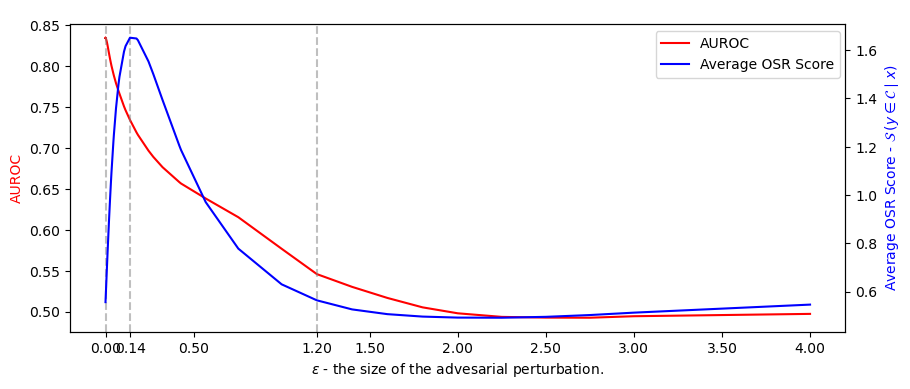

{'dim': -1, 'ord': None}
{'dim': -1, 'ord': None}
{'dim': -1, 'ord': None}


/Users/philip/DIKU/bachelor_project/our_modules/adv_tools.py:9: UserWarning: The operator 'aten::linalg_vector_norm' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525498485/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  return torch.linalg.norm(y_hat, **norm_kwargs)


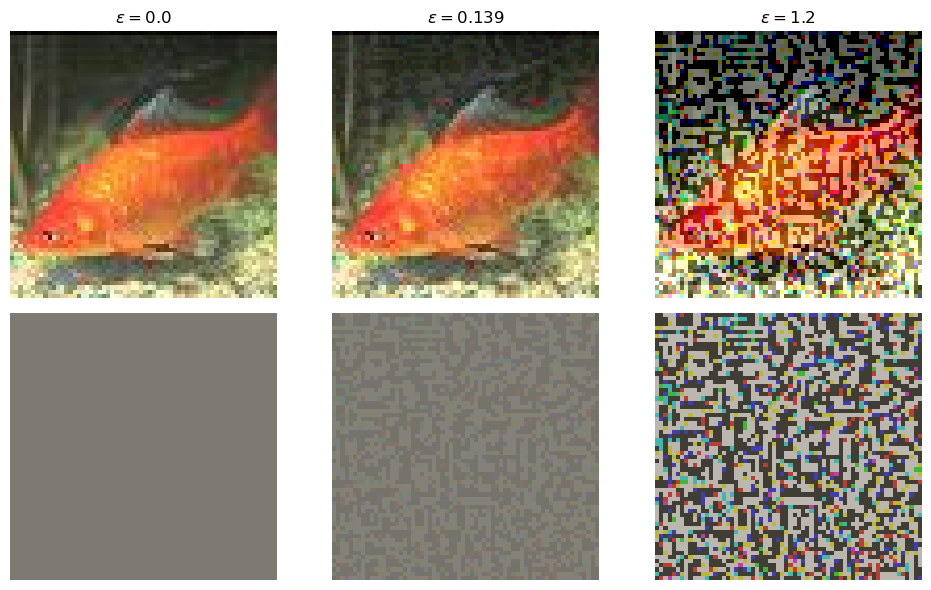

In [6]:
eps_exp_1 = EpsExperimentPlot(which_lines='both', add_zoom=False)
eps_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/inf_norm/', 0, True)
highlight_eps_idx = [0, 48, -10]
eps_exp_1.set_legend_and_highlight_eps(highlight_eps_idx, legend_loc=(0.72, 0.8))
eps_exp_1.show_and_save()

highlight_eps = eps_exp_1.recent_eps[highlight_eps_idx]
plot_adv_imgs(highlight_eps, *perturb_tin_image(highlight_eps, tin_goldfish, path_to_pretrained_weights_folder, device, split_num=0, 
                                                                      attack=fn_osr_fgsm, norm_ord=torch.inf),
              mean=tin_mean, std=tin_std, figsize=(10,6))

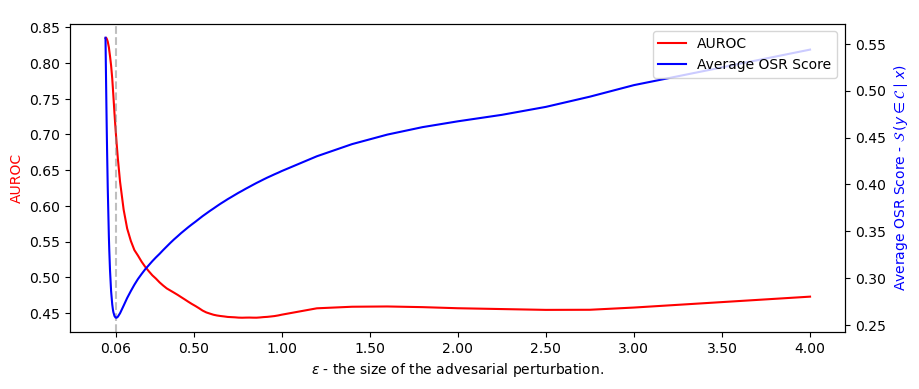

In [7]:
eps_exp_2 = EpsExperimentPlot(add_zoom=False)
eps_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True)
eps_exp_2.set_legend_and_highlight_eps([23], legend_loc=(0.71,0.8))
eps_exp_2.show_and_save()

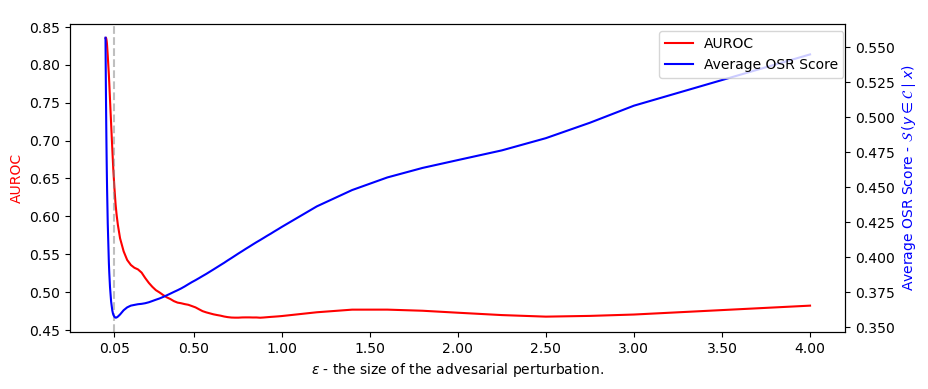

In [8]:
eps_exp_3 = EpsExperimentPlot(add_zoom=False)
eps_exp_3.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/inf_norm/', 0, True)
eps_exp_3.set_legend_and_highlight_eps([21], legend_loc=(0.71,0.8))
eps_exp_3.show_and_save()

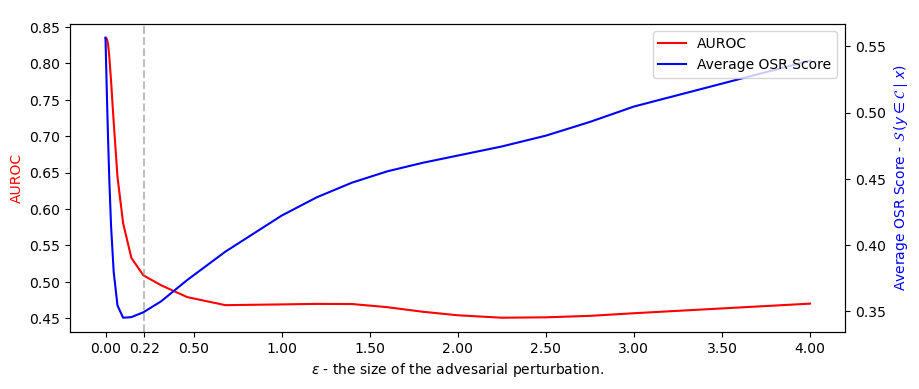

In [9]:
eps_exp_4 = EpsExperimentPlot(add_zoom=False)
eps_exp_4.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/sum_exp/', 0, True)
eps_exp_4.set_legend_and_highlight_eps([21], legend_loc=(0.71,0.8))
eps_exp_4.show_and_save()

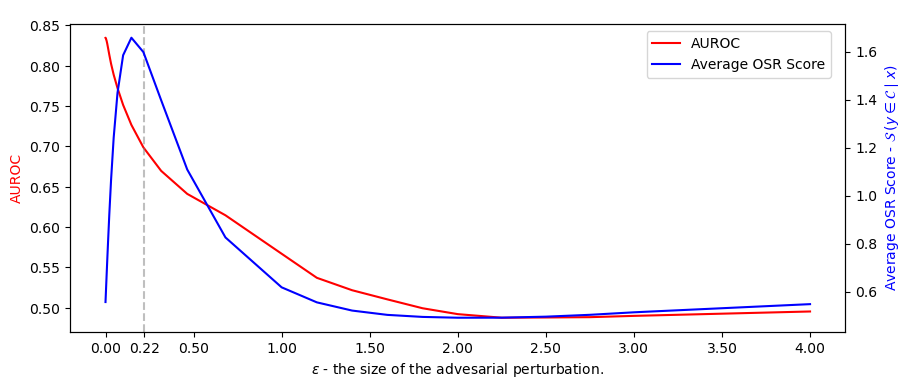

In [10]:
eps_exp_4 = EpsExperimentPlot(add_zoom=False)
eps_exp_4.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/log_msp/', 0, True)
eps_exp_4.set_legend_and_highlight_eps([21], legend_loc=(0.71,0.8))
eps_exp_4.show_and_save()

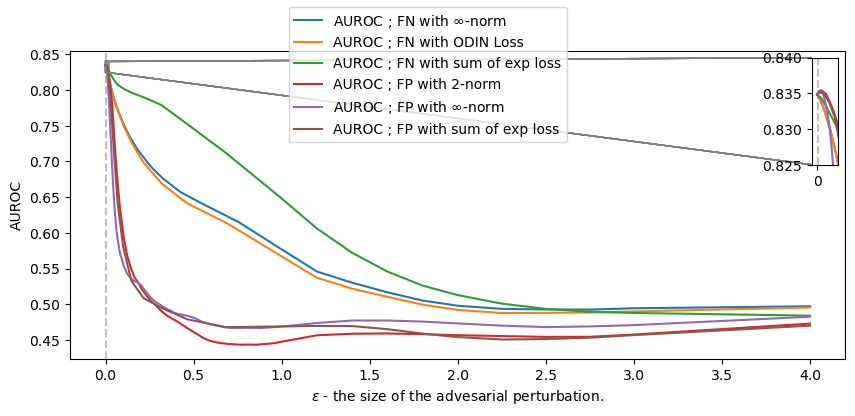

In [11]:
comparison_exp_1 = EpsExperimentPlot(which_lines='AUROC')
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/inf_norm/', 0, True, label_suffix=' ; FN with $\\infty$-norm')
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/log_msp/', 0, True, label_suffix= ' ; FN with ODIN Loss')
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/sum_exp/', 0, True, label_suffix= ' ; FN with sum of exp loss')
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True, label_suffix=' ; FP with 2-norm')
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/inf_norm/', 0, True, label_suffix= ' ; FP with $\\infty$-norm')
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/sum_exp/', 0, True, label_suffix= ' ; FP with sum of exp loss')
comparison_exp_1.set_legend_and_highlight_eps(legend_loc='upper center', eps_idxs = [4])
comparison_exp_1.show_and_save()

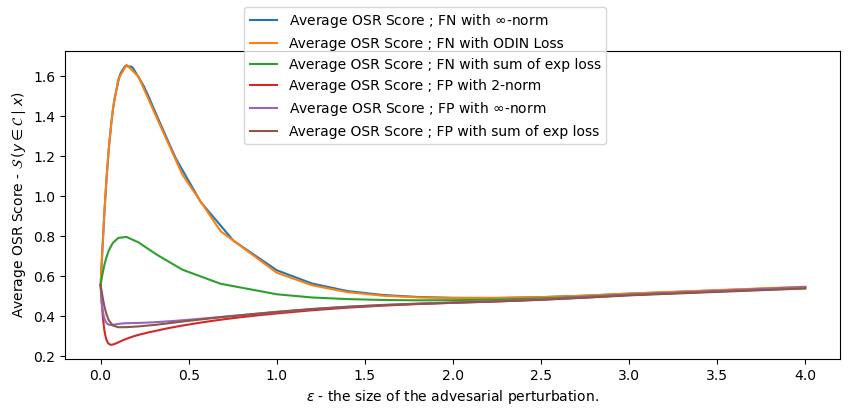

In [12]:
comparison_exp_2 = EpsExperimentPlot(which_lines='mls', add_zoom=False)
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/inf_norm/', 0, True, label_suffix=' ; FN with $\\infty$-norm')
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/log_msp/', 0, True, label_suffix= ' ; FN with ODIN Loss')
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/sum_exp/', 0, True, label_suffix= ' ; FN with sum of exp loss')
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True, label_suffix=' ; FP with 2-norm')
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/inf_norm/', 0, True, label_suffix= ' ; FP with $\\infty$-norm')
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/sum_exp/', 0, True, label_suffix= ' ; FP with sum of exp loss')
comparison_exp_2.set_legend_and_highlight_eps(legend_loc='upper center')
comparison_exp_2.show_and_save()

## Plotting FGSM perturbations

{'dim': -1, 'ord': None}


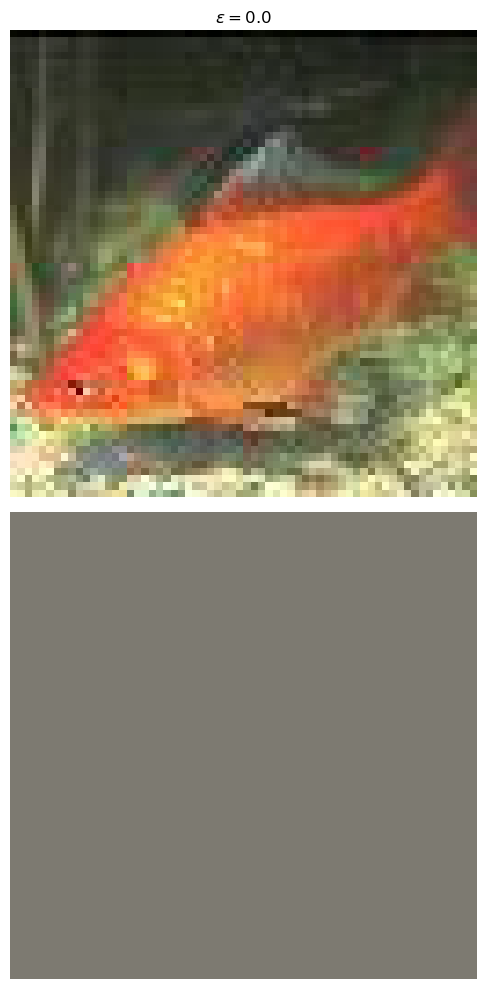

In [13]:
these_eps = [0.0]
plot_adv_imgs(these_eps, 
              *perturb_tin_image(these_eps, tin_goldfish, path_to_pretrained_weights_folder, device, split_num=0, attack=fn_osr_fgsm, norm_ord=None),
              mean=tin_mean, std=tin_std)

## FGSM attacks on the ROC curve

In [14]:
roc_stats_plain = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/plain/logits_0.pt", root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                      0, dataset_name='tinyimagenet', balance=True)
# roc_stats_fp, _ = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/fgsm_fp_attack/logits_split_0.pt", root_dir + "logits/tinyimagenet/plain/csr_targets_split_0.pt",
#                                       0, dataset_name='tinyimagenet')
roc_stats_fn = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/fp/fgsm/two_norm/eps_0.0622/logits_0.pt", 
                                        root_dir + "logits/tinyimagenet/fp/fgsm/two_norm/eps_0.0622/csr_targets_0.pt",
                                        0, dataset_name='tinyimagenet', balance=True)

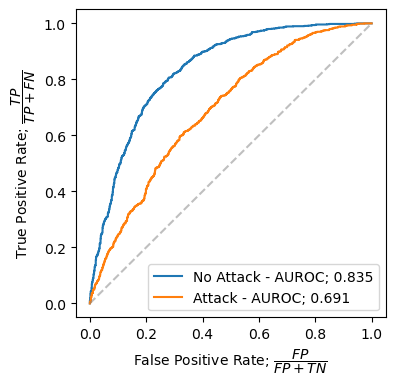

In [15]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
plot_roc(ax, roc_stats_plain[0], label=f'No Attack - AUROC; {roc_stats_plain[1]:.3}')
# plot_roc(ax, roc_stats_fp, label="FP attack")
plot_roc(ax, roc_stats_fn[0], label=f'Attack - AUROC; {roc_stats_fn[1]:.3}')
ax.plot([0,1],[0,1], linestyle='--', alpha=0.5, c='gray')
ax.set_xlabel("False Positive Rate; $\\dfrac{FP}{FP + TN}$")
ax.set_ylabel("True Positive Rate; $\\dfrac{TP}{TP + FN}$")
plt.legend(loc='lower right')
plt.show()

{'dim': -1, 'ord': None}
{'dim': -1, 'ord': None}


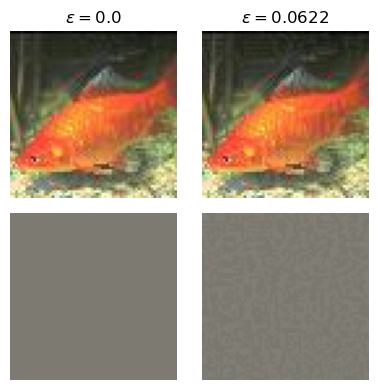

In [16]:
these_eps = [0.0, 0.0622]
plot_adv_imgs(these_eps, 
              *perturb_tin_image(these_eps, tin_goldfish, path_to_pretrained_weights_folder, device, split_num=0, attack=fp_osr_fgsm, norm_ord=None),
              mean=tin_mean, std=tin_std, figsize=(4,4))

### Informed Attack

In [17]:
roc_stats_plain = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/plain/logits_0.pt", root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                      0, dataset_name='tinyimagenet', balance=True)
# roc_stats_fp, _ = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/fgsm_fp_attack/logits_split_0.pt", root_dir + "logits/tinyimagenet/plain/csr_targets_split_0.pt",
#                                       0, dataset_name='tinyimagenet')
roc_stats_exp1 = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/informed/fgsm/exp1/logits_0.pt", 
                                        root_dir + "logits/tinyimagenet/informed/fgsm/exp1/csr_targets_0.pt",
                                        0, dataset_name='tinyimagenet', balance=True)
roc_stats_exp2 = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/informed/fgsm/exp2/logits_0.pt", 
                                        root_dir + "logits/tinyimagenet/informed/fgsm/exp2/csr_targets_0.pt",
                                        0, dataset_name='tinyimagenet', balance=True)
roc_stats_exp3 = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/informed/fgsm/exp3/logits_0.pt", 
                                        root_dir + "logits/tinyimagenet/informed/fgsm/exp3/csr_targets_0.pt",
                                        0, dataset_name='tinyimagenet', balance=True)


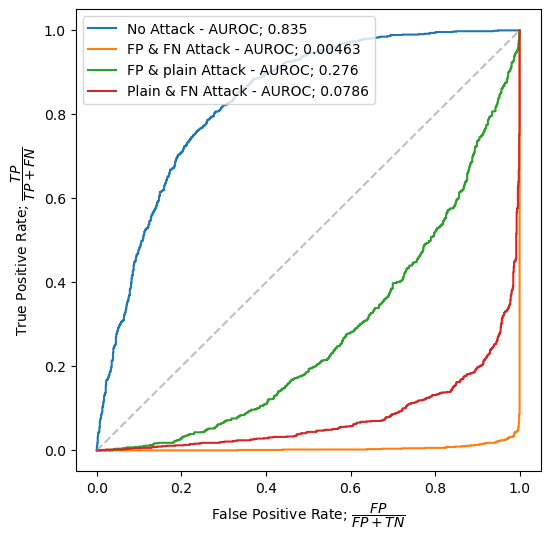

In [18]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
plot_roc(ax, roc_stats_plain[0], label=f'No Attack - AUROC; {roc_stats_plain[1]:.3}')
# plot_roc(ax, roc_stats_fp, label="FP attack")
plot_roc(ax, roc_stats_exp1[0], label=f'FP & FN Attack - AUROC; {roc_stats_exp1[1]:.3}')
plot_roc(ax, roc_stats_exp2[0], label=f'FP & plain Attack - AUROC; {roc_stats_exp2[1]:.3}')
plot_roc(ax, roc_stats_exp3[0], label=f'Plain & FN Attack - AUROC; {roc_stats_exp3[1]:.3}')
ax.plot([0,1],[0,1], linestyle='--', alpha=0.5, c='gray')
ax.set_xlabel("False Positive Rate; $\\dfrac{FP}{FP + TN}$")
ax.set_ylabel("True Positive Rate; $\\dfrac{TP}{TP + FN}$")
plt.legend(loc='upper left')
plt.show()

{'dim': -1, 'ord': inf}
{'dim': -1, 'ord': inf}


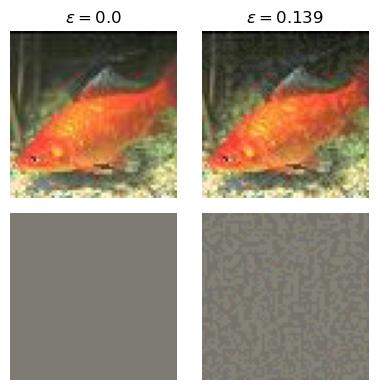

{'dim': -1, 'ord': None}
{'dim': -1, 'ord': None}


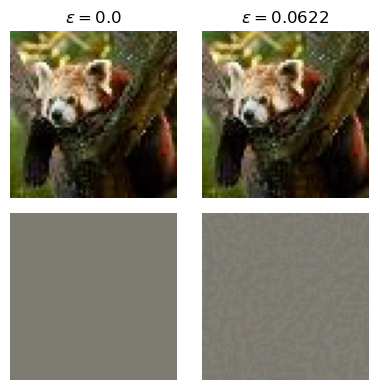

In [19]:
these_eps = [0.0, 0.139]
plot_adv_imgs(these_eps, 
              *perturb_tin_image(these_eps, tin_goldfish, path_to_pretrained_weights_folder, device, split_num=0, attack=fn_osr_fgsm, norm_ord=torch.inf),
              mean=tin_mean, std=tin_std, figsize=(4,4))

these_eps = [0.0, 0.0622]
plot_adv_imgs(these_eps, 
              *perturb_tin_image(these_eps, tin_panda, path_to_pretrained_weights_folder, device, split_num=0, attack=fp_osr_fgsm, norm_ord=None),
              mean=tin_mean, std=tin_std, figsize=(4,4))

## Visualizing ID vs OOD sensitivity to adversarial attacks

### Grad Norm

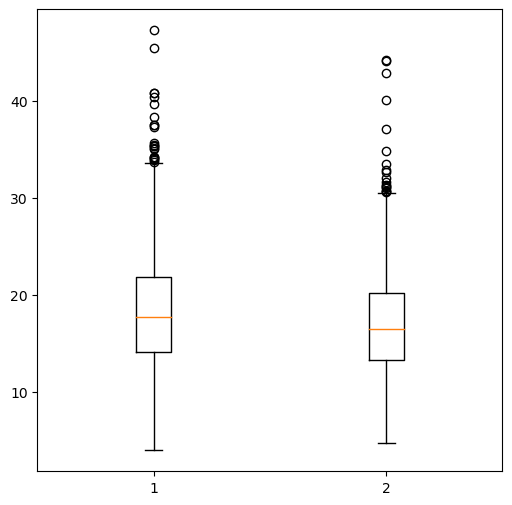

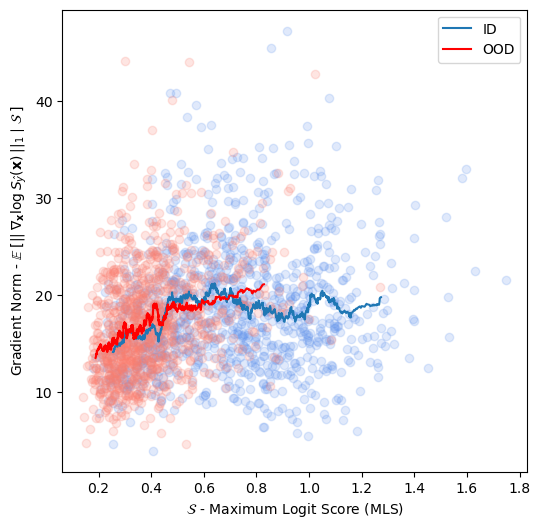

In [20]:
# Norm of log_msp gradients ID vs OOD
scatter_log_msp_grad_norms = IdOodPlot()
scatter_log_msp_grad_norms.load_grad_norm_stats(tin_grad_norm_dir + 'log_msp/', root_dir + 'logits/tinyimagenet/plain/', split_num=0, balance=True)
scatter_log_msp_grad_norms.make_boxplot()
scatter_log_msp_grad_norms.show_and_save()
scatter_log_msp_grad_norms.make_scatter_plot(window_size=25)
# scatter_log_msp_grad_norms.ax.set_ylabel(r'Gradient Norm - $||\:\nabla_{\bf{x}} \log S_{\hat{y}}({\bf{x}}) \:||_1$')
scatter_log_msp_grad_norms.set_legend()
scatter_log_msp_grad_norms.show_and_save()

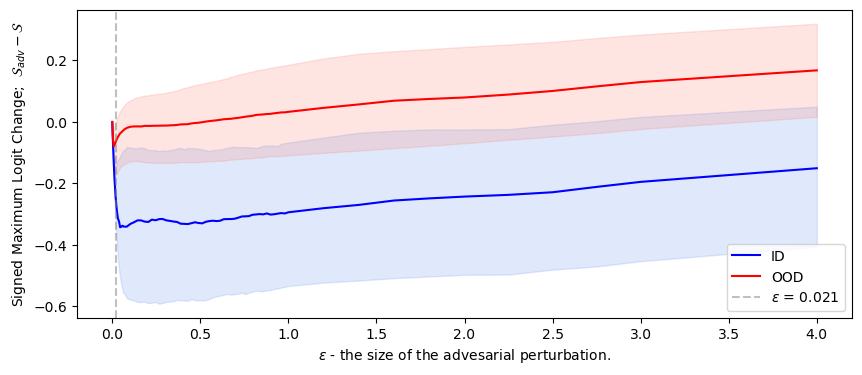

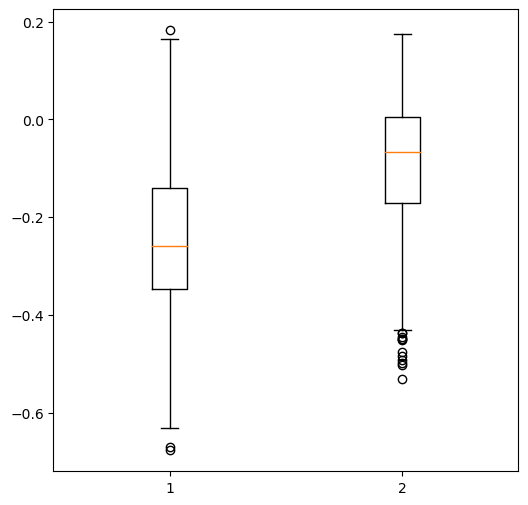

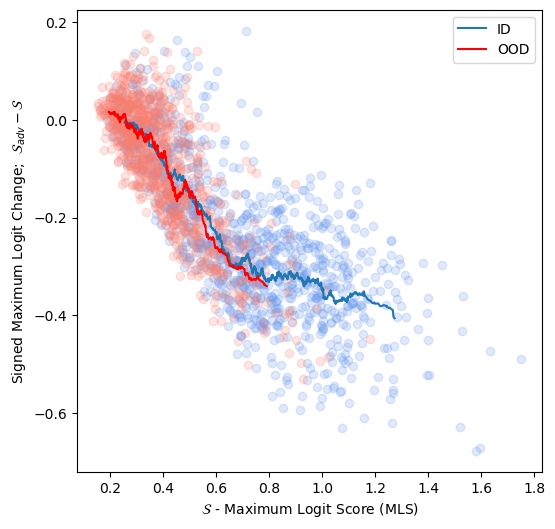

In [21]:
plot_diff_stats_for_eps(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                       root_dir + "logits/tinyimagenet/fp/fgsm/inf_norm/",
                       root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                       split_num = 0, 
                       dataset_name='tinyimagenet',
                       figsize=(10,4),
                       highlight_eps_idx=15)

scatter_mls_diffs = IdOodPlot()
scatter_mls_diffs.load_mls_diffs_stats(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/fp/fgsm/inf_norm/eps_0.0214/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                                                0, dataset_name='tinyimagenet', balance=True)
scatter_mls_diffs.make_boxplot()
scatter_mls_diffs.show_and_save()
scatter_mls_diffs.make_scatter_plot(window_size=25, ylabel=r'Signed Maximum Logit Change;  $\mathcal{S}_{adv} - \mathcal{S}$')
scatter_mls_diffs.set_legend()
scatter_mls_diffs.show_and_save()


### Max Logit Change

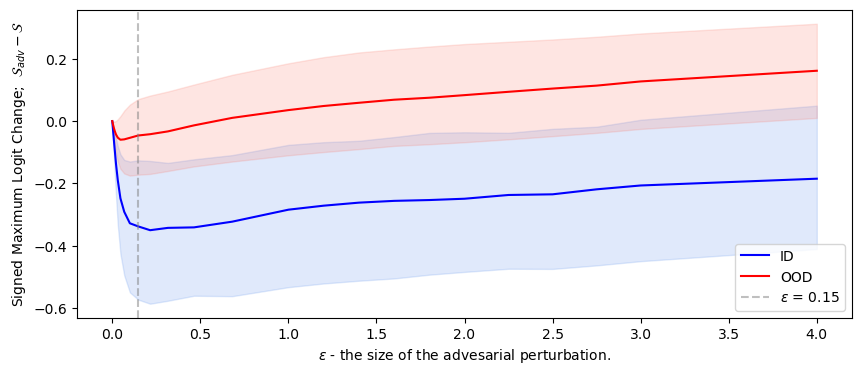

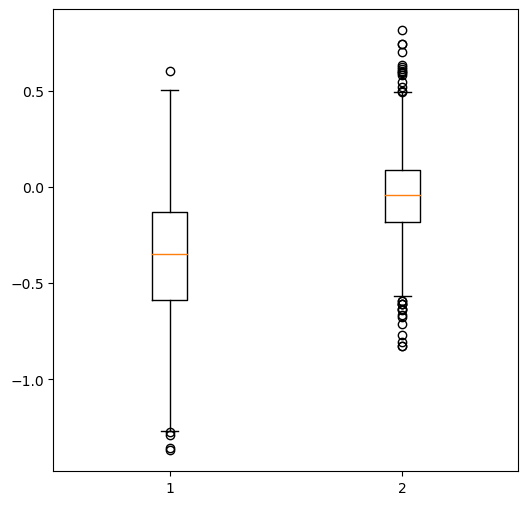

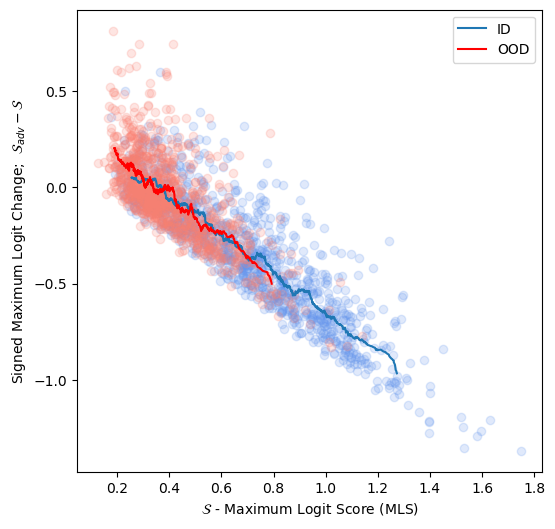

In [22]:
plot_diff_stats_for_eps(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                       root_dir + "logits/tinyimagenet/fp/fgsm/sum_exp/",
                       root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                       split_num = 0, 
                       dataset_name='tinyimagenet',
                       figsize=(10,4),
                       highlight_eps_idx=20)

scatter_mls_diffs = IdOodPlot()
scatter_mls_diffs.load_mls_diffs_stats(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/fp/fgsm/sum_exp/eps_0.215/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                                                0, dataset_name='tinyimagenet', balance=True)
scatter_mls_diffs.make_boxplot()
scatter_mls_diffs.show_and_save()
scatter_mls_diffs.make_scatter_plot(window_size=25, ylabel=r'Signed Maximum Logit Change;  $\mathcal{S}_{adv} - \mathcal{S}$')
scatter_mls_diffs.set_legend()
scatter_mls_diffs.show_and_save()


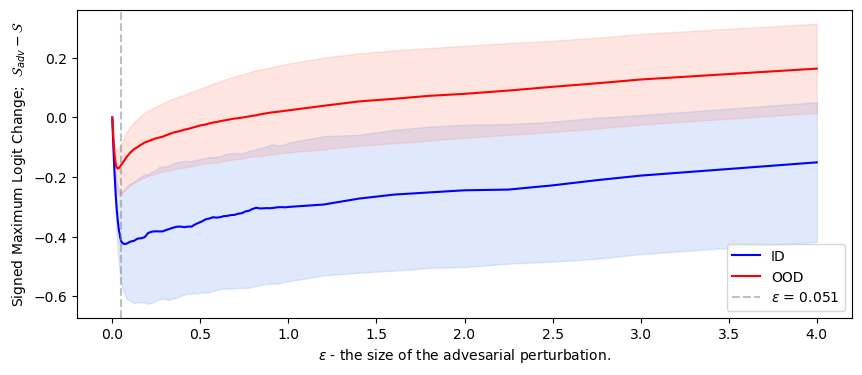

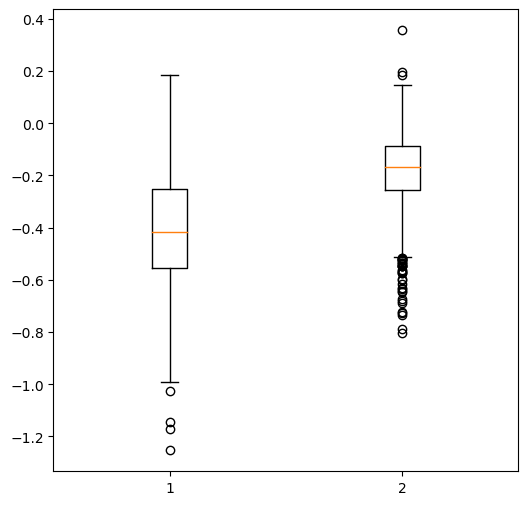

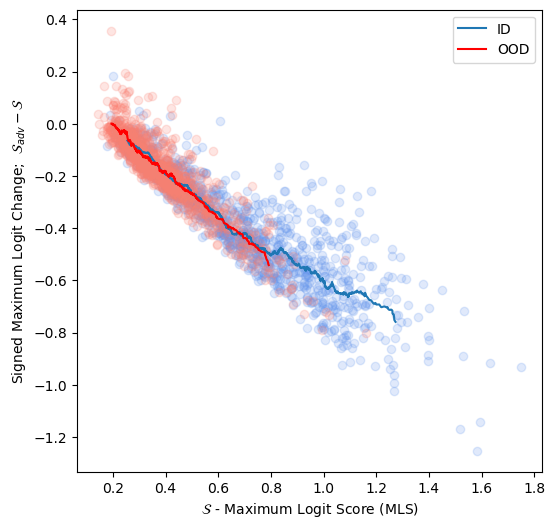

In [23]:
plot_diff_stats_for_eps(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                       root_dir + "logits/tinyimagenet/fp/fgsm/two_norm/",
                       root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                       split_num = 0, 
                       dataset_name='tinyimagenet',
                       figsize=(10,4),
                       highlight_eps_idx=21)

scatter_mls_diffs = IdOodPlot()
scatter_mls_diffs.load_mls_diffs_stats(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/fp/fgsm/two_norm/eps_0.0509/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                                                0, dataset_name='tinyimagenet', balance=True)
scatter_mls_diffs.make_boxplot()
scatter_mls_diffs.show_and_save()
scatter_mls_diffs.make_scatter_plot(window_size=25, ylabel=r'Signed Maximum Logit Change;  $\mathcal{S}_{adv} - \mathcal{S}$')
scatter_mls_diffs.set_legend()
scatter_mls_diffs.show_and_save()

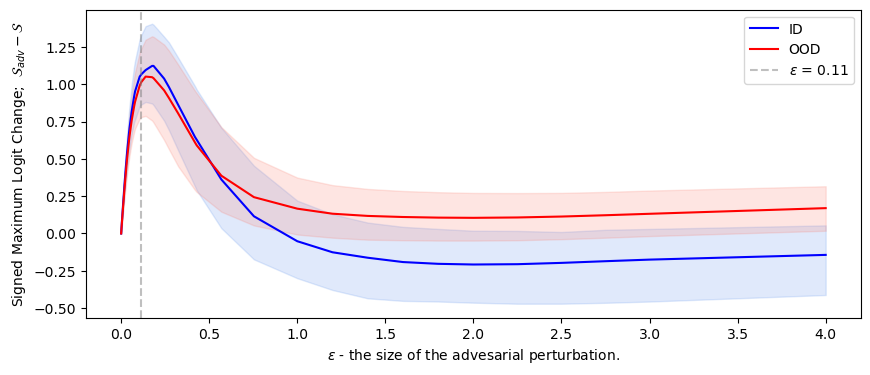

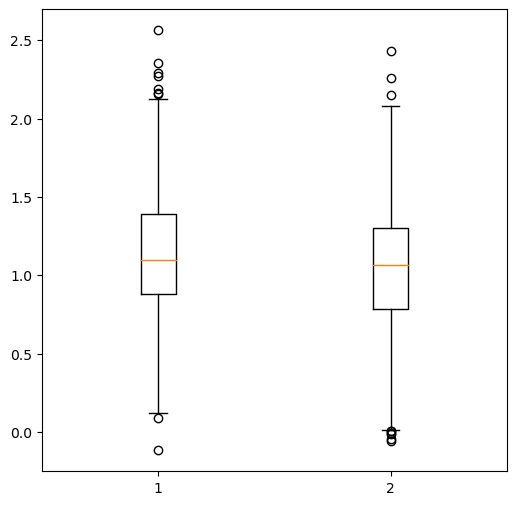

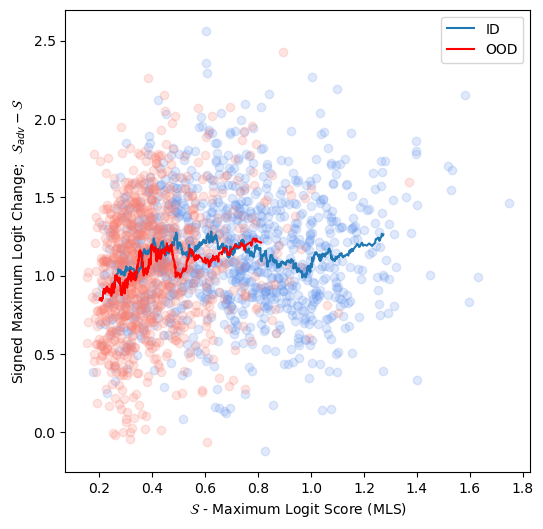

In [24]:
plot_diff_stats_for_eps(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                       root_dir + "logits/tinyimagenet/fn/fgsm/inf_norm/",
                       root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                       split_num = 0, 
                       dataset_name='tinyimagenet',
                       figsize=(10,4),
                       highlight_eps_idx=47)

scatter_mls_diffs = IdOodPlot()
scatter_mls_diffs.load_mls_diffs_stats(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/fn/fgsm/inf_norm/eps_0.139/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                                                0, dataset_name='tinyimagenet', balance=True)
scatter_mls_diffs.make_boxplot()
scatter_mls_diffs.show_and_save()
scatter_mls_diffs.make_scatter_plot(window_size=25, ylabel=r'Signed Maximum Logit Change;  $\mathcal{S}_{adv} - \mathcal{S}$')
scatter_mls_diffs.set_legend()
scatter_mls_diffs.show_and_save()

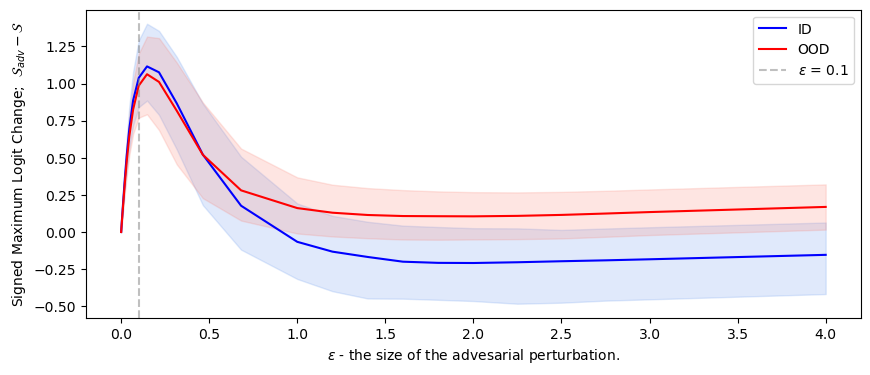

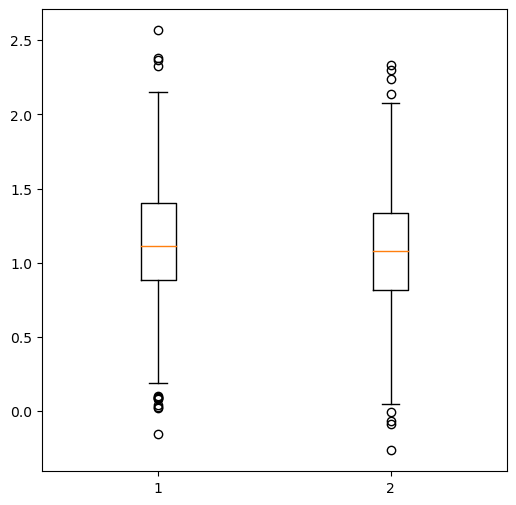

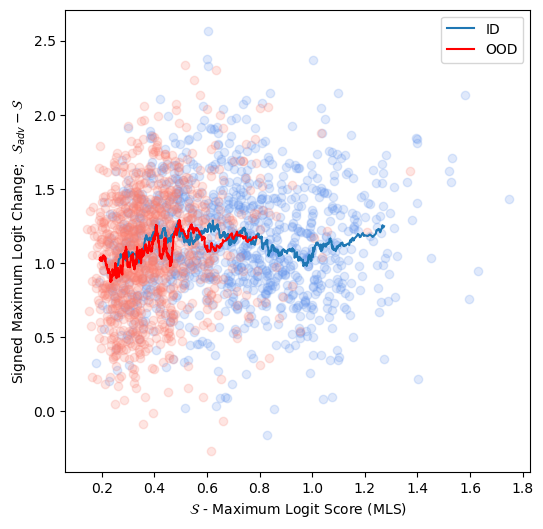

In [25]:
plot_diff_stats_for_eps(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                       root_dir + "logits/tinyimagenet/fn/fgsm/log_msp/",
                       root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                       split_num = 0, 
                       dataset_name='tinyimagenet',
                       figsize=(10,4),
                       highlight_eps_idx=19)

scatter_mls_diffs = IdOodPlot()
scatter_mls_diffs.load_mls_diffs_stats(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/fn/fgsm/log_msp/eps_0.147/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                                                0, dataset_name='tinyimagenet', balance=True)
scatter_mls_diffs.make_boxplot()
scatter_mls_diffs.show_and_save()
scatter_mls_diffs.make_scatter_plot(window_size=25, ylabel=r'Signed Maximum Logit Change;  $\mathcal{S}_{adv} - \mathcal{S}$')
scatter_mls_diffs.set_legend()
scatter_mls_diffs.show_and_save()

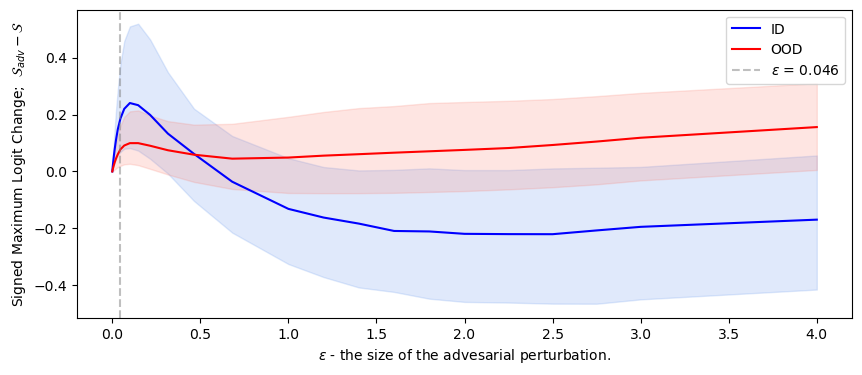

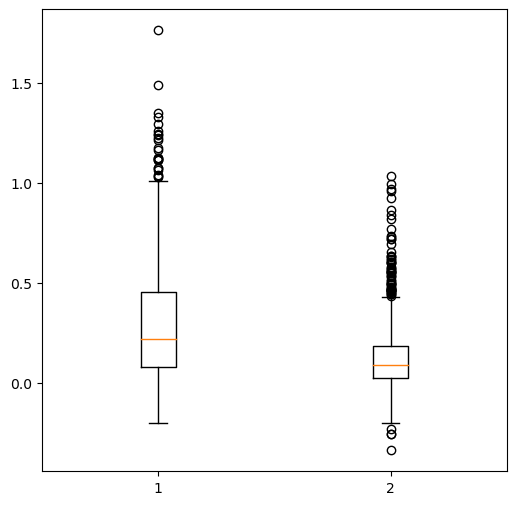

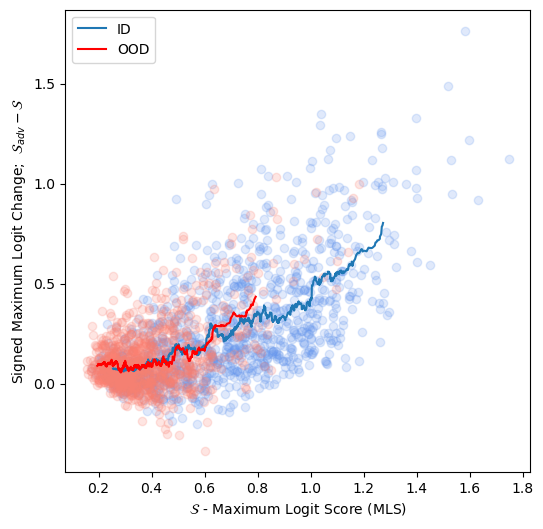

In [26]:
plot_diff_stats_for_eps(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                       root_dir + "logits/tinyimagenet/fn/fgsm/sum_exp/",
                       root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                       split_num = 0, 
                       dataset_name='tinyimagenet',
                       figsize=(10,4),
                       highlight_eps_idx=17)

scatter_mls_diffs = IdOodPlot()
scatter_mls_diffs.load_mls_diffs_stats(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/fn/fgsm/sum_exp/eps_0.0681/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                                                0, dataset_name='tinyimagenet', balance=True)
scatter_mls_diffs.make_boxplot()
scatter_mls_diffs.show_and_save()
scatter_mls_diffs.make_scatter_plot(window_size=25, ylabel=r'Signed Maximum Logit Change;  $\mathcal{S}_{adv} - \mathcal{S}$')
scatter_mls_diffs.set_legend()
scatter_mls_diffs.show_and_save()

## Logit Change scoring rules

### Maximum Logit Change

FP 2-norm

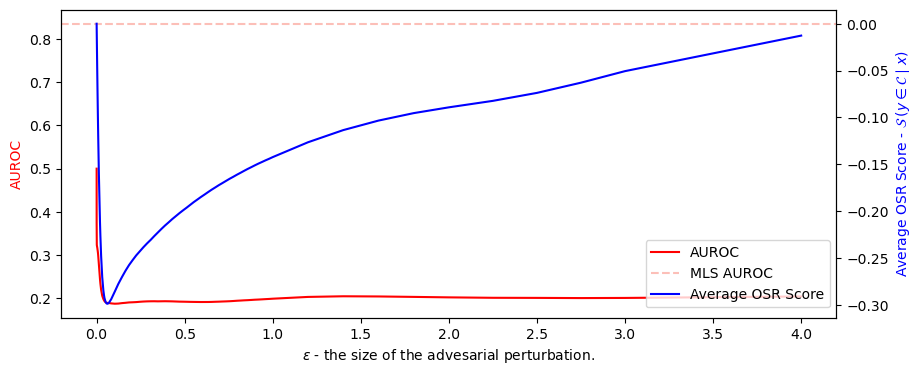

In [27]:
mlc_plot_fp_two_norm = EpsExperimentPlot(add_zoom=None)
mlc_plot_fp_two_norm.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fp/fgsm/two_norm/', tin_logits_dir + 'plain/logits_0.pt', 0)
mlc_plot_fp_two_norm.set_legend_and_highlight_eps(legend_loc=(0.70,0.18), h_line=0.835)

FP inf-norm

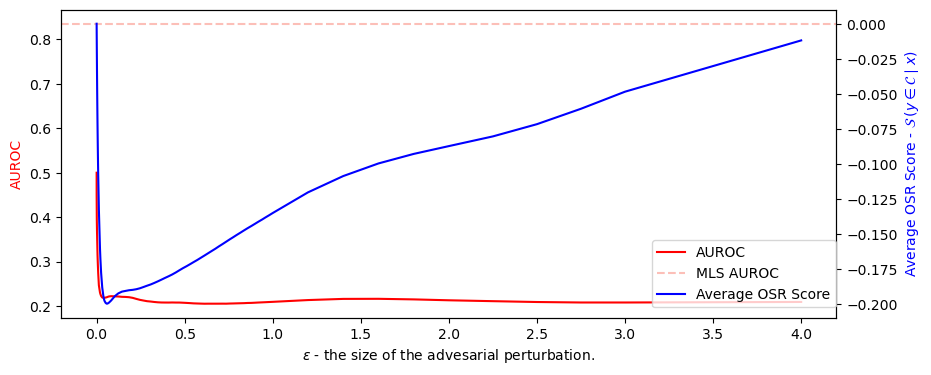

In [28]:
mlc_plot_fp_inf_norm = EpsExperimentPlot(add_zoom=None)
mlc_plot_fp_inf_norm.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fp/fgsm/inf_norm/', tin_logits_dir + 'plain/logits_0.pt', 0)
mlc_plot_fp_inf_norm.set_legend_and_highlight_eps(legend_loc=(0.70,0.18), h_line=0.835)

FP sum_exp

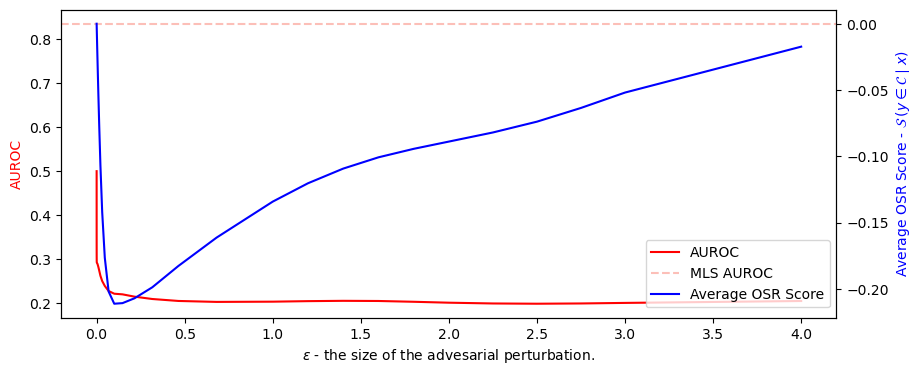

In [29]:
mlc_plot_fp_sum_exp = EpsExperimentPlot(add_zoom=None)
mlc_plot_fp_sum_exp.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fp/fgsm/sum_exp/', tin_logits_dir + 'plain/logits_0.pt', 0)
mlc_plot_fp_sum_exp.set_legend_and_highlight_eps(legend_loc=(0.70,0.18), h_line=0.835)

FN inf-norm

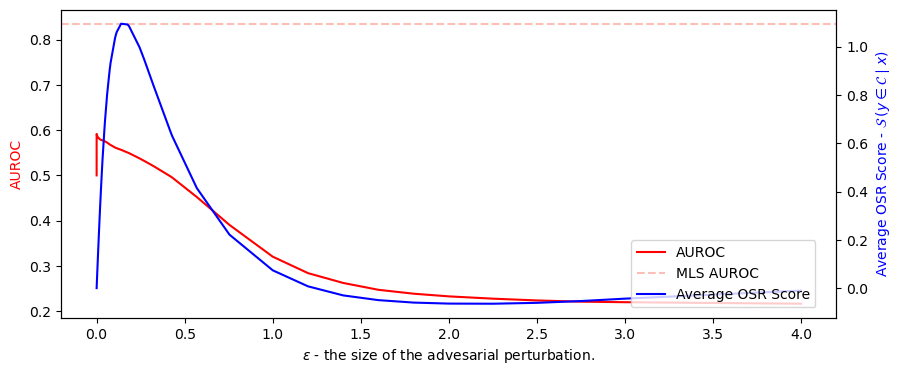

In [30]:
mlc_plot_fn_inf_norm = EpsExperimentPlot(add_zoom=None)
mlc_plot_fn_inf_norm.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fn/fgsm/inf_norm/', tin_logits_dir + 'plain/logits_0.pt', 0)
mlc_plot_fn_inf_norm.set_legend_and_highlight_eps(legend_loc=(0.70,0.18), h_line=0.835)

FN log_msp

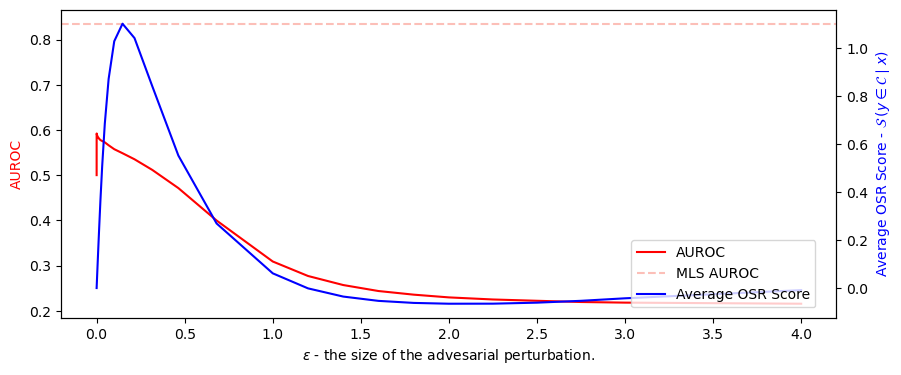

In [31]:
mlc_plot_fn_log_msp = EpsExperimentPlot(add_zoom=None)
mlc_plot_fn_log_msp.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fn/fgsm/log_msp/', tin_logits_dir + 'plain/logits_0.pt', 0)
mlc_plot_fn_log_msp.set_legend_and_highlight_eps(legend_loc=(0.70,0.18), h_line=0.835)

FN sum_exp

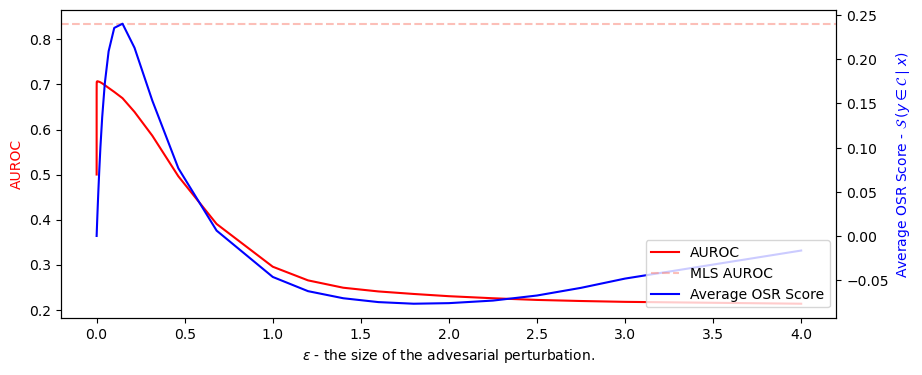

In [32]:
mlc_plot_fn_sum_exp = EpsExperimentPlot(add_zoom=None)
mlc_plot_fn_sum_exp.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fn/fgsm/sum_exp/', tin_logits_dir + 'plain/logits_0.pt', 0)
mlc_plot_fn_sum_exp.set_legend_and_highlight_eps(legend_loc=(0.70,0.18), h_line=0.835)

Comparing the AUROC curves

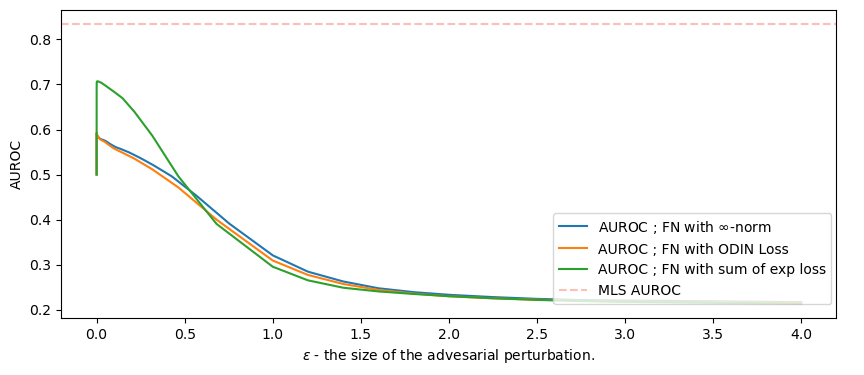

In [33]:
auroc_comparison = EpsExperimentPlot(which_lines='AUROC', add_zoom=None)
# auroc_comparison.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fp/fgsm/two_norm/', tin_logits_dir + 'plain/logits_0.pt', 0, label_suffix=' ; FP with 2-norm')
# auroc_comparison.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fp/fgsm/inf_norm/', tin_logits_dir + 'plain/logits_0.pt', 0, label_suffix= ' ; FP with $\\infty$-norm')
# auroc_comparison.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fp/fgsm/sum_exp/', tin_logits_dir + 'plain/logits_0.pt', 0, label_suffix= ' ; FP with sum of exp loss')
auroc_comparison.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fn/fgsm/inf_norm/', tin_logits_dir + 'plain/logits_0.pt', 0, label_suffix=' ; FN with $\\infty$-norm')
auroc_comparison.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fn/fgsm/log_msp/', tin_logits_dir + 'plain/logits_0.pt', 0, label_suffix= ' ; FN with ODIN Loss')
auroc_comparison.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fn/fgsm/sum_exp/', tin_logits_dir + 'plain/logits_0.pt', 0, label_suffix= ' ; FN with sum of exp loss')

auroc_comparison.set_legend_and_highlight_eps(legend_loc=(0.64,0.19), h_line=0.835)

## Iterative Attack

In [6]:
test_model = get_model_for_split(0,path_to_pretrained_weights_folder,device=device)
for i in range(20):
    img = tin_dataset[i][0]
    img = img[None,:]
    test_img, test_step = iterative_attack(test_model, img.to(device), torch.zeros_like(img), lambda yhat, y: torch.max(yhat), torch.optim.Rprop, clip_range=tin_clip_range, return_step=True, max_iter=25, step_sizes=(1e-06, 5e-03))
    test_img = torch.clip(test_img, tin_clip_range[0], tin_clip_range[1])
    print('max change to pixel: {}'.format(torch.max(torch.abs(test_step))))
    #print('change to max logti: {}'.format(torch.abs(torch.max(test_model(img[None].to(device)))-torch.max(test_model(test_img[None].to(device))))))



/opt/homebrew/anaconda3/lib/python3.9/site-packages/torch/optim/rprop.py:204: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525849783/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  sign[sign.gt(0)] = etaplus


change before clip: 0.0
- = out of range max: 0.0
+ = our of range min: -0.01938486099243164
change after clip: 0.0
max change to pixel: 0.0
change before clip: 0.0
- = out of range max: 0.29779791831970215
+ = our of range min: -0.949063777923584
change after clip: 0.0
max change to pixel: 0.0
change before clip: 0.0
- = out of range max: 0.0
+ = our of range min: -0.01081085205078125
change after clip: 0.0
max change to pixel: 0.0
change before clip: 0.0
- = out of range max: 0.23964333534240723
+ = our of range min: -0.01081085205078125
change after clip: 0.0
max change to pixel: 0.0
change before clip: 0.0
- = out of range max: 0.0
+ = our of range min: 0.0
change after clip: 0.0
max change to pixel: 0.0
change before clip: 0.0
- = out of range max: 0.23964333534240723
+ = our of range min: -0.1091451644897461
change after clip: 0.0
max change to pixel: 0.0
change before clip: 0.0
- = out of range max: 0.0
+ = our of range min: 0.0
change after clip: 0.0
max change to pixel: 0.0
ch

In [7]:
test_model = get_model_for_split(0,path_to_pretrained_weights_folder,device=device)
for i in range(20):
    img = tin_dataset[i][0]
    test_img, test_step = iterative_attack(test_model, img.to(device), torch.zeros_like(img), lambda yhat, y: torch.max(yhat), torch.optim.Rprop, clip_range=tin_clip_range, return_step=True, max_iter=25, step_sizes=(1e-06, 5e-03))
    test_img = torch.clip(test_img, tin_clip_range[0], tin_clip_range[1])
    print('max change to pixel: {}'.format(torch.max(torch.abs(test_step))))
    #print('change to max logti: {}'.format(torch.abs(torch.max(test_model(img[None].to(device)))-torch.max(test_model(test_img[None].to(device))))))

0.12500286102294922
max change to pixel: 0.12500286102294922
0.11342000961303711
max change to pixel: 0.11342000961303711
0.12500154972076416
max change to pixel: 0.12500154972076416
0.12500178813934326
max change to pixel: 0.12500178813934326
0.12499994039535522
max change to pixel: 0.12499994039535522
0.12499989569187164
max change to pixel: 0.12499989569187164
0.1249999850988388
max change to pixel: 0.1249999850988388
0.11342000961303711
max change to pixel: 0.11342000961303711
0.12500286102294922
max change to pixel: 0.12500286102294922
0.12500286102294922
max change to pixel: 0.12500286102294922
0.12499988079071045
max change to pixel: 0.12499988079071045
0.12500286102294922
max change to pixel: 0.12500286102294922
0.12499988079071045
max change to pixel: 0.12499988079071045
0.12499988079071045
max change to pixel: 0.12499988079071045
0.11999988555908203
max change to pixel: 0.11999988555908203
0.12500286102294922
max change to pixel: 0.12500286102294922
0.1140998899936676
max cha

In [144]:
test_model = get_model_for_split(0,path_to_pretrained_weights_folder,device=device)

tensor(0.1250, grad_fn=<MaxBackward1>)
tensor(0.7354, device='mps:0', grad_fn=<AbsBackward0>)


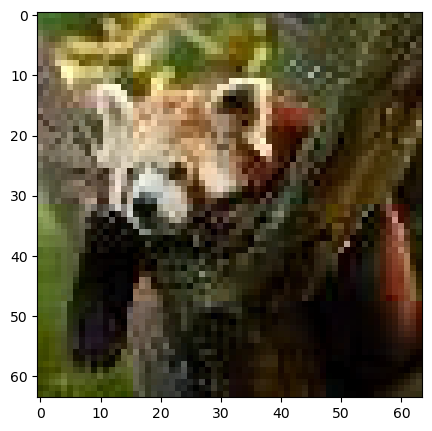

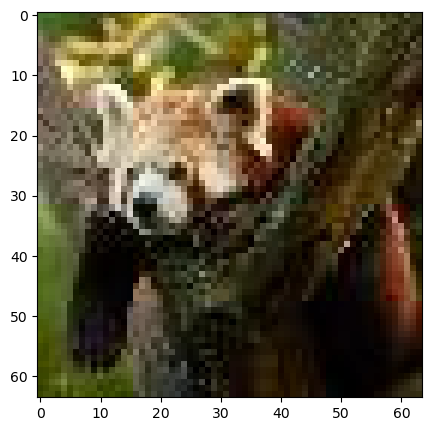

In [145]:
test_img = torch.clip(test_img, tin_clip_range[0], tin_clip_range[1])
print(torch.max(torch.abs((test_img.to('cpu') - tin_panda))))
print(torch.abs(torch.max(test_model(tin_panda[None].to(device)))-torch.max(test_model(test_img[None].to(device)))))
plot_image(test_img, mean=tin_mean, std=tin_std)
plot_image(tin_panda, mean=tin_mean, std=tin_std)

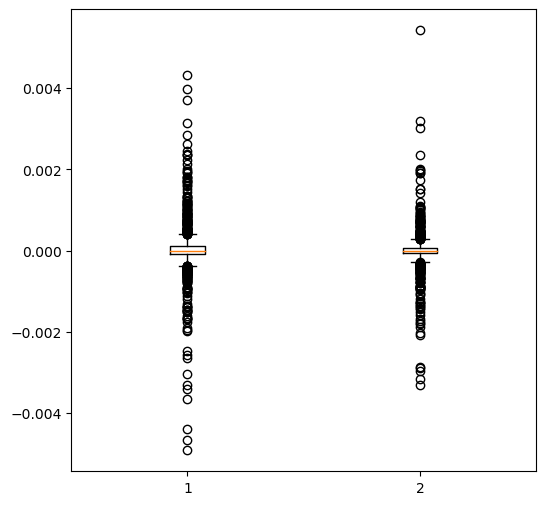

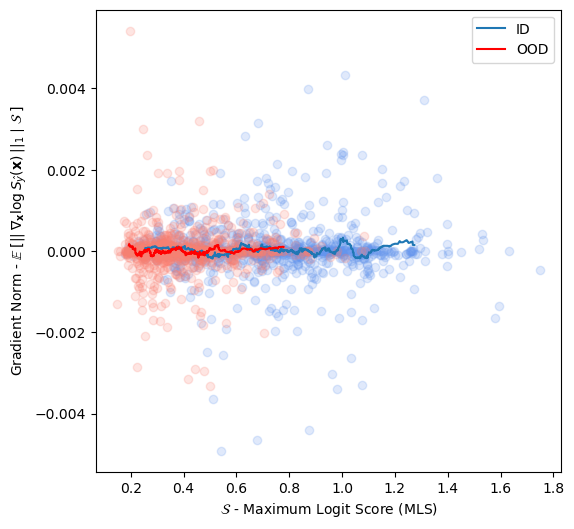

In [122]:
scatter_ia = IdOodPlot()
scatter_ia.load_mls_diffs_stats(root_dir + 'logits/tinyimagenet/plain/logits_0.pt', root_dir + 'logits/tinyimagenet/fn/ia/test/logits_0.pt', root_dir + 'logits/tinyimagenet/plain/csr_targets_0.pt', split_num=0, balance=True)
scatter_ia.make_boxplot()
scatter_ia.make_scatter_plot(window_size=25)
# scatter_log_msp_grad_norms.ax.set_ylabel(r'Gradient Norm - $||\:\nabla_{\bf{x}} \log S_{\hat{y}}({\bf{x}}) \:||_1$')
scatter_ia.set_legend()
scatter_ia.show_and_save()

In [6]:
run_max = 0.0
run_min = 0.0
for i in range(10):
    img = tin_dataset[i][0]
    run_max = max(torch.amax(img).item(),run_max)
    run_min = min(torch.amin(img).item(),run_min)
print(run_min,run_max)
    

-2.429065704345703 2.7537312507629395
